In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from plot_learning_curve import plot_learning_curve, plot_validation_curve
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
import mlrose_hiive

None


In [2]:
credit_train = pd.read_csv("credit-a.tsv", sep = "\t")
credit_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,target
0,2,156,0.000,2,1,13,8,1.25,1,1,1.0,0,0,42,0.0,0
1,1,328,4.460,2,1,11,4,3.04,1,1,6.0,0,0,118,560.0,0
2,1,89,0.500,2,1,11,4,1.50,1,0,0.0,0,0,74,824.0,0
3,2,125,1.540,2,1,13,8,3.75,1,1,5.0,1,0,1,3.0,0
4,2,43,5.625,2,1,13,8,1.71,1,0,0.0,0,2,8,0.0,0


In [3]:
credit_train['target'].value_counts()/credit_train.shape[0]

1    0.555072
0    0.444928
Name: target, dtype: float64

In [4]:
normalize_columns = ['A2', 'A3', 'A6','A8', 'A11', 'A14']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  credit_train[columns] = scaler.fit_transform(credit_train[columns])
normalize(normalize_columns)

In [5]:
X = credit_train[[c for c in credit_train.columns if c != 'target']]
y = credit_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [34]:
"""
NN MLrose
"""
base_clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[80], activation='relu',
                           algorithm = 'gradient_descent',early_stopping = True,
                           max_attempts = 200, max_iters = 500,
                           bias = True, learning_rate = .005,
                           restarts=0, curve = True, random_state=42)

In [35]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7671034363068379
Test Accuracy:  0.775


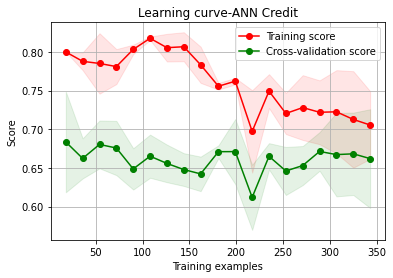

In [8]:
plot_learning_curve(base_clf, "Learning curve-ANN Credit", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [40]:
param_grid = {
        'hidden_nodes': [[2], [4], [8], [16], [32], [64], [96], [128]], #[(32), (64), (64, 64), (128), (128,128)], #, (32, 64, 32), (64, 128, 64)],
        'learning_rate': [0.000001, 0.00001, 0.0001, 0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 1]
      }

In [41]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 80 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   45.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=4,
             estimator=NeuralNetwork(algorithm='gradient_descent', curve=True,
                                     early_stopping=True, hidden_nodes=[80],
                                     learning_rate=0.005, max_attempts=200,
                                     max_iters=500, random_state=42),
             n_jobs=-1,
             param_grid={'hidden_nodes': [[2], [4], [8], [16], [32], [64], [96],
                                          [128]],
                         'learning_rate': [1e-06, 1e-05, 0.0001, 0.001, 0.002,
                                           0.005, 0.01, 0.05, 0.1, 1]},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [38]:
grid_search.best_score_

0.7069057229575393

In [39]:
grid_search.best_params_

{'learning_rate': 0.001}

In [42]:
grid_search.best_estimator_

NeuralNetwork(algorithm='gradient_descent', curve=True, early_stopping=True,
              hidden_nodes=[128], learning_rate=0.001, max_attempts=200,
              max_iters=500, random_state=42)

In [56]:
test_clf = mlrose_hiive.NeuralNetwork(algorithm='gradient_descent', curve=True, early_stopping=True,
              hidden_nodes=[128], learning_rate=0.001, max_attempts=200,
              max_iters=500, random_state=42)
test_clf.fit(X_train, y_train)
y_train_pred = grid_search.best_estimator_.predict(X_train)
y_test_pred = grid_search.best_estimator_.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8235074626865672
Test Accuracy:  0.7402173913043478


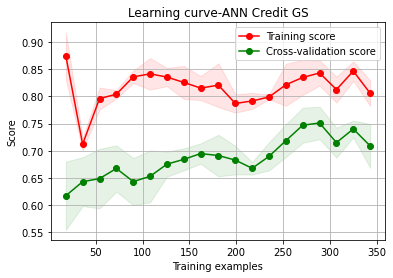

In [57]:
plot_learning_curve(grid_search.best_estimator_, "Learning curve-ANN Credit GS", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [107]:
"""
Random Hill Climb
"""
rhc_clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[128], activation='relu',
                           algorithm = 'random_hill_climb', early_stopping = True,
                           max_attempts = 1000, max_iters = 50000,
                           bias = True, learning_rate = .001,
                           restarts=5, curve = True, random_state=42)

In [108]:
rhc_clf.fit(X_train, y_train)
y_train_pred = rhc_clf.predict(X_train)
y_test_pred = rhc_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.7103436306837904
Test Accuracy:  0.6586956521739131


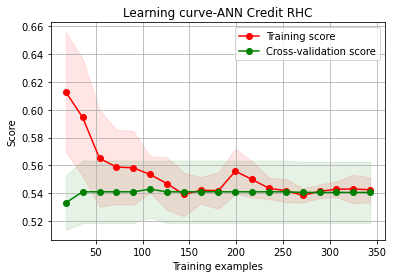

In [63]:
plot_learning_curve(rhc_clf, "Learning curve-ANN Credit RHC", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [112]:
"""
Simulated Annealing
"""
sa_clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[128], activation='relu',
                           algorithm = 'simulated_annealing', early_stopping = True,
                           max_attempts = 500, max_iters = 25000,
                           bias = True, learning_rate = .001,
                           restarts=0, curve = True, random_state=42, schedule=mlrose_hiive.GeomDecay(10000))

In [113]:
sa_clf.fit(X_train, y_train)
y_train_pred = sa_clf.predict(X_train)
y_test_pred = sa_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.5389187782020132
Test Accuracy:  0.5195652173913043


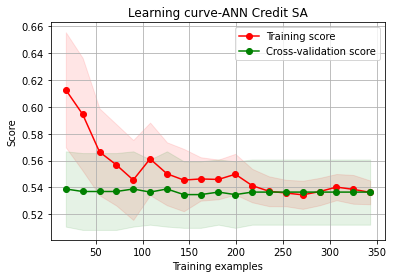

In [83]:
plot_learning_curve(sa_clf, "Learning curve-ANN Credit SA", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

In [115]:
"""
Genetic Algorithm
"""
ga_clf = mlrose_hiive.NeuralNetwork(hidden_nodes=[128], activation='relu',
                           algorithm = 'genetic_alg', early_stopping = True,
                           max_attempts = 200, max_iters = 2000,
                           bias = True, learning_rate = .001,
                           restarts=0, curve = True, random_state=42, pop_size=5000, mutation_prob=0.35)

In [ ]:
ga_clf.fit(X_train, y_train)
y_train_pred = ga_clf.predict(X_train)
y_test_pred = ga_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

In [105]:
ga_clf.fitness_curve[:,0]

array([10.7265168 , 10.7265168 , 10.4405029 , 10.15435657,  9.58227415,
        9.58227415,  9.58227415,  9.58227415,  9.51083648,  9.51083648,
        9.51083648,  9.51083648,  9.51083648,  9.51083648,  8.93875738,
        8.93875738,  8.93875738,  8.93875738,  8.93875738,  8.93874082,
        8.93874082,  8.93874082,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79576119,
        8.79576119,  8.79576119,  8.79576119,  8.79576119,  8.79

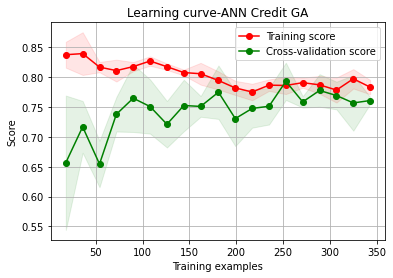

In [84]:
plot_learning_curve(ga_clf, "Learning curve-ANN Credit GA", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

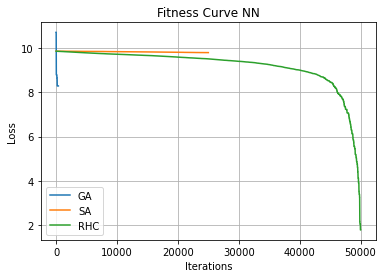

In [114]:
plt.plot(ga_clf.fitness_curve[:,0], label="GA")
plt.plot(sa_clf.fitness_curve[:,0], label="SA")
plt.plot(rhc_clf.fitness_curve[:,0], label = "RHC")
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid()
plt.title("Fitness Curve NN")
plt.savefig("Fitness Curve NN")